In [1]:
import torch 
from torch import nn
import torchvision
import matplotlib.pyplot as plt 

In [2]:
from pathlib import Path

# Load the dataset path
data_path = Path("Celebrities/")
image_path = data_path

print(image_path)

Celebrities


In [3]:
# Set up the training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test" 

train_dir, test_dir

(WindowsPath('Celebrities/train'), WindowsPath('Celebrities/test'))

Random image path: Celebrities\train\Angelina_Jolie\079_40a598dc.jpg
Image class: Angelina_Jolie
Image height: 592
Image width: 474


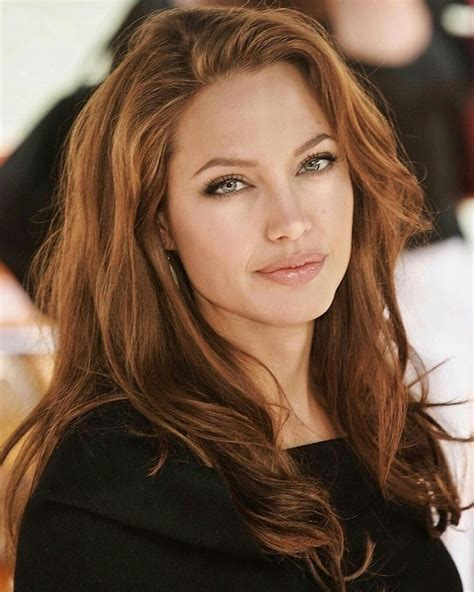

In [4]:
import random
from PIL import Image

# Visualize an image 

# List all the images in the image_path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Choose a random image
random_image_path = random.choice(image_path_list)

# Get the class of the image
image_class = random_image_path.parent.stem

# Open the image
img = Image.open(random_image_path)

# Display the image, class and shape
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2

In [145]:
data_transformation = v2.Compose([v2.ToImage(), 
                v2.Resize((64, 64)), 
                v2.ToDtype(torch.float32),])

In [140]:
def dataset_loading (train_dir, 
                test_dir, 
                data_transformation):
    

    train_dataset = datasets.ImageFolder(root=train_dir, 
                                    transform=data_transformation) 

    test_dataset = datasets.ImageFolder(root=test_dir,
                                    transform=data_transformation)

    train_percent = len(train_dataset)/(len(train_dataset) + len(test_dataset))

    print("------------------------------------------------------------------")
    print(f"Train dataset: {train_dataset}, Test dataset: {test_dataset}")
    print(f'Train dataset length: {len(train_dataset)}')
    print(f'Test dataset length: {len(test_dataset)}')
    print(f'% of Train: {train_percent*100}')
    print(f'% of Test: {(1 - train_percent)*100}')
    print("--------------------------------------------------------------------")

    return train_dataset, test_dataset

In [146]:
train_dataset, test_dataset = dataset_loading(
                    train_dir=train_dir, 
                    test_dir=test_dir, 
                    data_transformation=data_transformation)

------------------------------------------------------------------
Train dataset: Dataset ImageFolder
    Number of datapoints: 580
    Root location: Celebrities\train
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToDtype(scale=False)
           ), Test dataset: Dataset ImageFolder
    Number of datapoints: 120
    Root location: Celebrities\test
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToDtype(scale=False)
           )
Train dataset length: 580
Test dataset length: 120
% of Train: 82.85714285714286
% of Test: 17.14285714285714
--------------------------------------------------------------------


In [147]:
BATCH_SIZE = 32 

train_dataloader = DataLoader(train_dataset, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True)

test_dataloader = DataLoader(test_dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=False)

train_dataloader.dataset, test_dataloader.dataset


(Dataset ImageFolder
     Number of datapoints: 580
     Root location: Celebrities\train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToDtype(scale=False)
            ),
 Dataset ImageFolder
     Number of datapoints: 120
     Root location: Celebrities\test
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  ToDtype(scale=False)
            ))

In [10]:
img, label = next(iter(train_dataloader))

print(f'Image shape {img.shape} ---> [batch size, color channels, height x width]')
print(f'Label shape: {label.shape}')

Image shape torch.Size([32, 3, 64, 64]) ---> [batch size, color channels, height x width]
Label shape: torch.Size([32])


In [222]:
## LET'S MAKE OUR CONVOLUTIONAL NEURAL NETWORK MODEL

import torch.nn.functional as F

class NestNet(nn.Module):
    def __init__(self):
        super(NestNet, self).__init__()
        self.block = nn.Sequential (
            nn.Conv2d(3, 32, 5),
            nn.Conv2d(32, 64, 5),
            nn.MaxPool2d(2,2), 
            nn.MaxPool2d(2,2))
        
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(3*3*5, 1296),
            nn.Linear(1296, 6)
        )

        self.dropout = nn.Sequential(
            nn.Dropout(0.45), 
            nn.Dropout(0.35)
        )

        self.Normalization = nn.Sequential(
            nn.BatchNorm2d(32), 
            nn.BatchNorm2d(64)
        )

    def forward(self, x):
        x = self.block(x)
        print(x.shape)
        x = F.relu(self.block(x))
        x = self.classifier(x)
        x = self.dropout(x)
        x = self.Normalization(x)
    
        return x

In [16]:
def train(model, 
        train_dataloader, 
        loss_function, 
        optimizer):
        
    model.train()

    train_loss, train_accuracy = 0,0
    for batch, (data, target) in enumerate (train_dataloader):

        output_logits = model(data)

        loss = loss_function(output_logits, target)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        predictions = torch.argmax(torch.softmax(output_logits, dim=1), dim=1) #convert to probabilities
        train_accuracy += ((predictions == target).sum().item()/len(output_logits))

    train_loss = train_loss/len(train_dataloader)
    train_accuracy = train_accuracy/len(train_dataloader)

    return train_loss, train_accuracy

def test(model, 
        test_dataloader, 
        loss_function):
    
    model.eval()

    test_loss, test_accuracy = 0, 0

    with torch.no_grad():
        for batch, (data, target) in enumerate (test_dataloader):

            output_logits = model(data)

            loss = loss_function(output_logits, target)
            test_loss += loss

            predictions = torch.argmax(torch.softmax(output_logits, dim=1), dim=1) #convert to probabilities
            test_accuracy += ((predictions == target).sum().item()/len(output_logits))

    test_loss = test_loss/len(test_dataloader)
    test_accuracy = test_accuracy/len(test_dataloader)

    return test_loss, test_accuracy


In [74]:
from tqdm.auto import tqdm

def working(model, 
            train_dataloader, 
            test_dataloader, 
            loss_function, 
            optimizer, 
            REPS): 
    
    results = {'train_loss': [], 
        'train_accuracy': [],
        'test_loss': [], 
        'test_accuracy': []
    }

    for i in tqdm(range(REPS), desc = "Working on the model..... "):

        train_loss, train_accuracy = train(model=model, 
                            train_dataloader=train_dataloader, 
                            loss_function=loss_function, 
                            optimizer=optimizer)
        
        test_loss, test_accuracy = test(model=model, 
                            test_dataloader=train_dataloader, 
                            loss_function=loss_function)
        
        print(
        f"Repetition: {i+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_accuracy: {test_accuracy:.4f}"
        )
        
        results['train_loss'].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results['train_accuracy'].append(train_accuracy.item() if isinstance(train_accuracy, torch.Tensor) else train_accuracy)
        results['test_loss'].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results['test_accuracy'].append(test_accuracy.item() if isinstance(test_accuracy, torch.Tensor) else test_accuracy)

    return results


In [223]:
torch.manual_seed(42)
REPS = 5
model_0 = NestNet()

loss_fn = nn.CrossEntropyLoss()
opti = torch.optim.SGD(model_0.parameters(), lr=0.005, weight_decay=0.05)

model_0_results = working(model_0, train_dataloader, test_dataloader,
                        loss_function=loss_fn, optimizer=opti,REPS=REPS)

Working on the model..... :   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 64, 14, 14])


RuntimeError: Given groups=1, weight of size [32, 3, 5, 5], expected input[32, 64, 14, 14] to have 3 channels, but got 64 channels instead

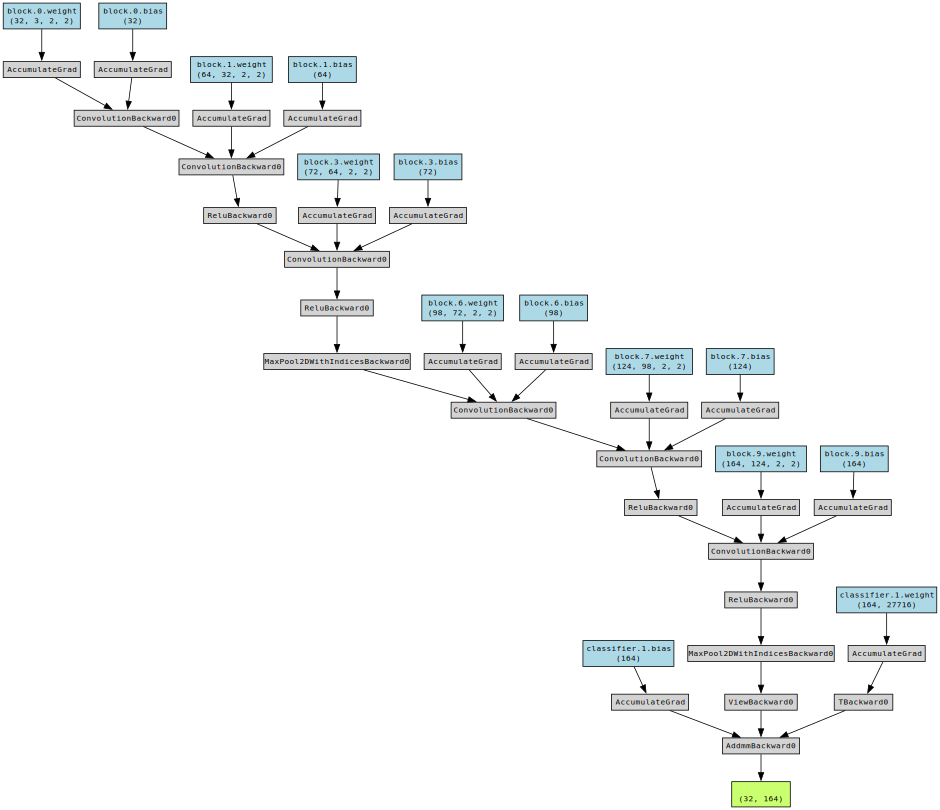

In [206]:
from torchviz import make_dot, make_dot_from_trace

x = torch.randn(32, 3, 64, 64)
y = model_0(x)

make_dot(y, params=dict(list(model_0.named_parameters()) + [('input', x)]))

In [169]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_accuracy']
    test_accuracy = results['test_accuracy']

    # Figure out how many epochs there were
    REPS = range(len(results['train_loss']))
    REPS2 =range(len(results['test_accuracy']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(REPS, loss, label='train_loss')
    plt.plot(REPS, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Repetitions')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(REPS2, accuracy, label='train_accuracy')
    plt.plot(REPS2, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Repetitions')
    plt.legend();


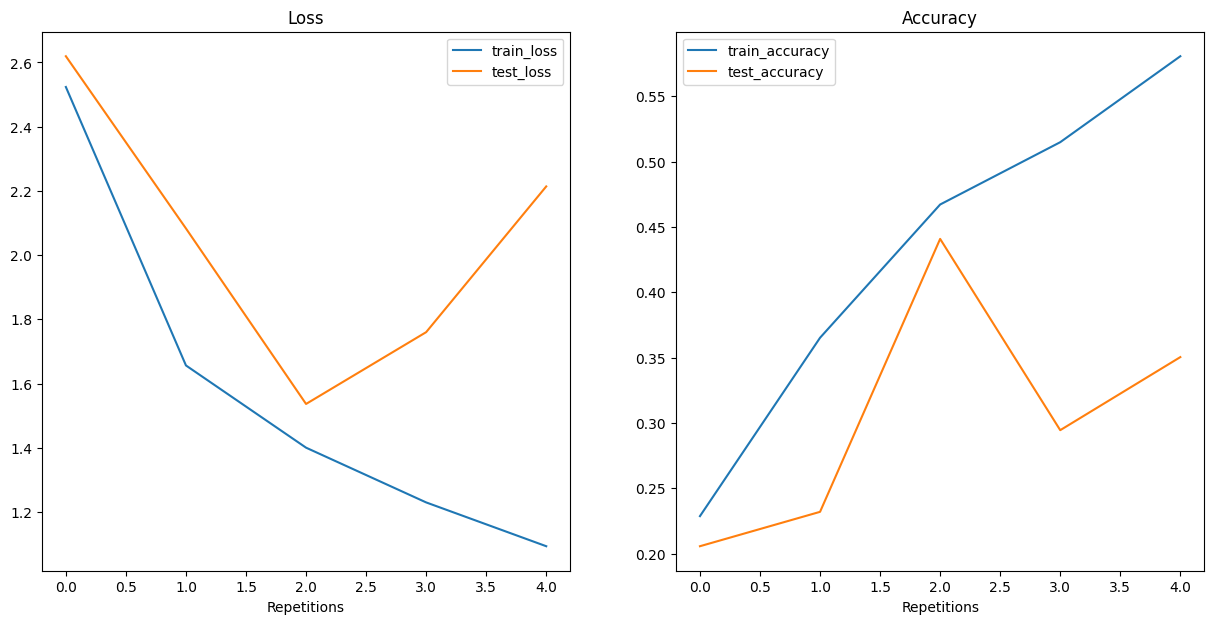

In [170]:
plot_loss_curves(model_0_results)

In [207]:
from torchinfo import summary
summary(model_0, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
NestNet                                  [32, 164]                 --
├─Sequential: 1-1                        [32, 164, 13, 13]         --
│    └─Conv2d: 2-1                       [32, 32, 63, 63]          416
│    └─Conv2d: 2-2                       [32, 64, 62, 62]          8,256
│    └─ReLU: 2-3                         [32, 64, 62, 62]          --
│    └─Conv2d: 2-4                       [32, 72, 61, 61]          18,504
│    └─ReLU: 2-5                         [32, 72, 61, 61]          --
│    └─MaxPool2d: 2-6                    [32, 72, 30, 30]          --
│    └─Conv2d: 2-7                       [32, 98, 29, 29]          28,322
│    └─Conv2d: 2-8                       [32, 124, 28, 28]         48,732
│    └─ReLU: 2-9                         [32, 124, 28, 28]         --
│    └─Conv2d: 2-10                      [32, 164, 27, 27]         81,508
│    └─ReLU: 2-11                        [32, 164, 27, 27]       

In [208]:
def make_predictions(model, data):

    pred_probs = []
    model.eval()

    with torch.no_grad():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0) 

            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            pred_probs.append(pred_prob)
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k=25): #k is the number of samples we want to take
    test_samples.append(sample)
    test_labels.append(label)

pred_probabilities = make_predictions(
                model=model_0, 
                data=test_samples)

# Actual classes
class_names = train_dataset.classes

#Predicted classes
pred_classes = pred_probabilities.argmax(dim=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

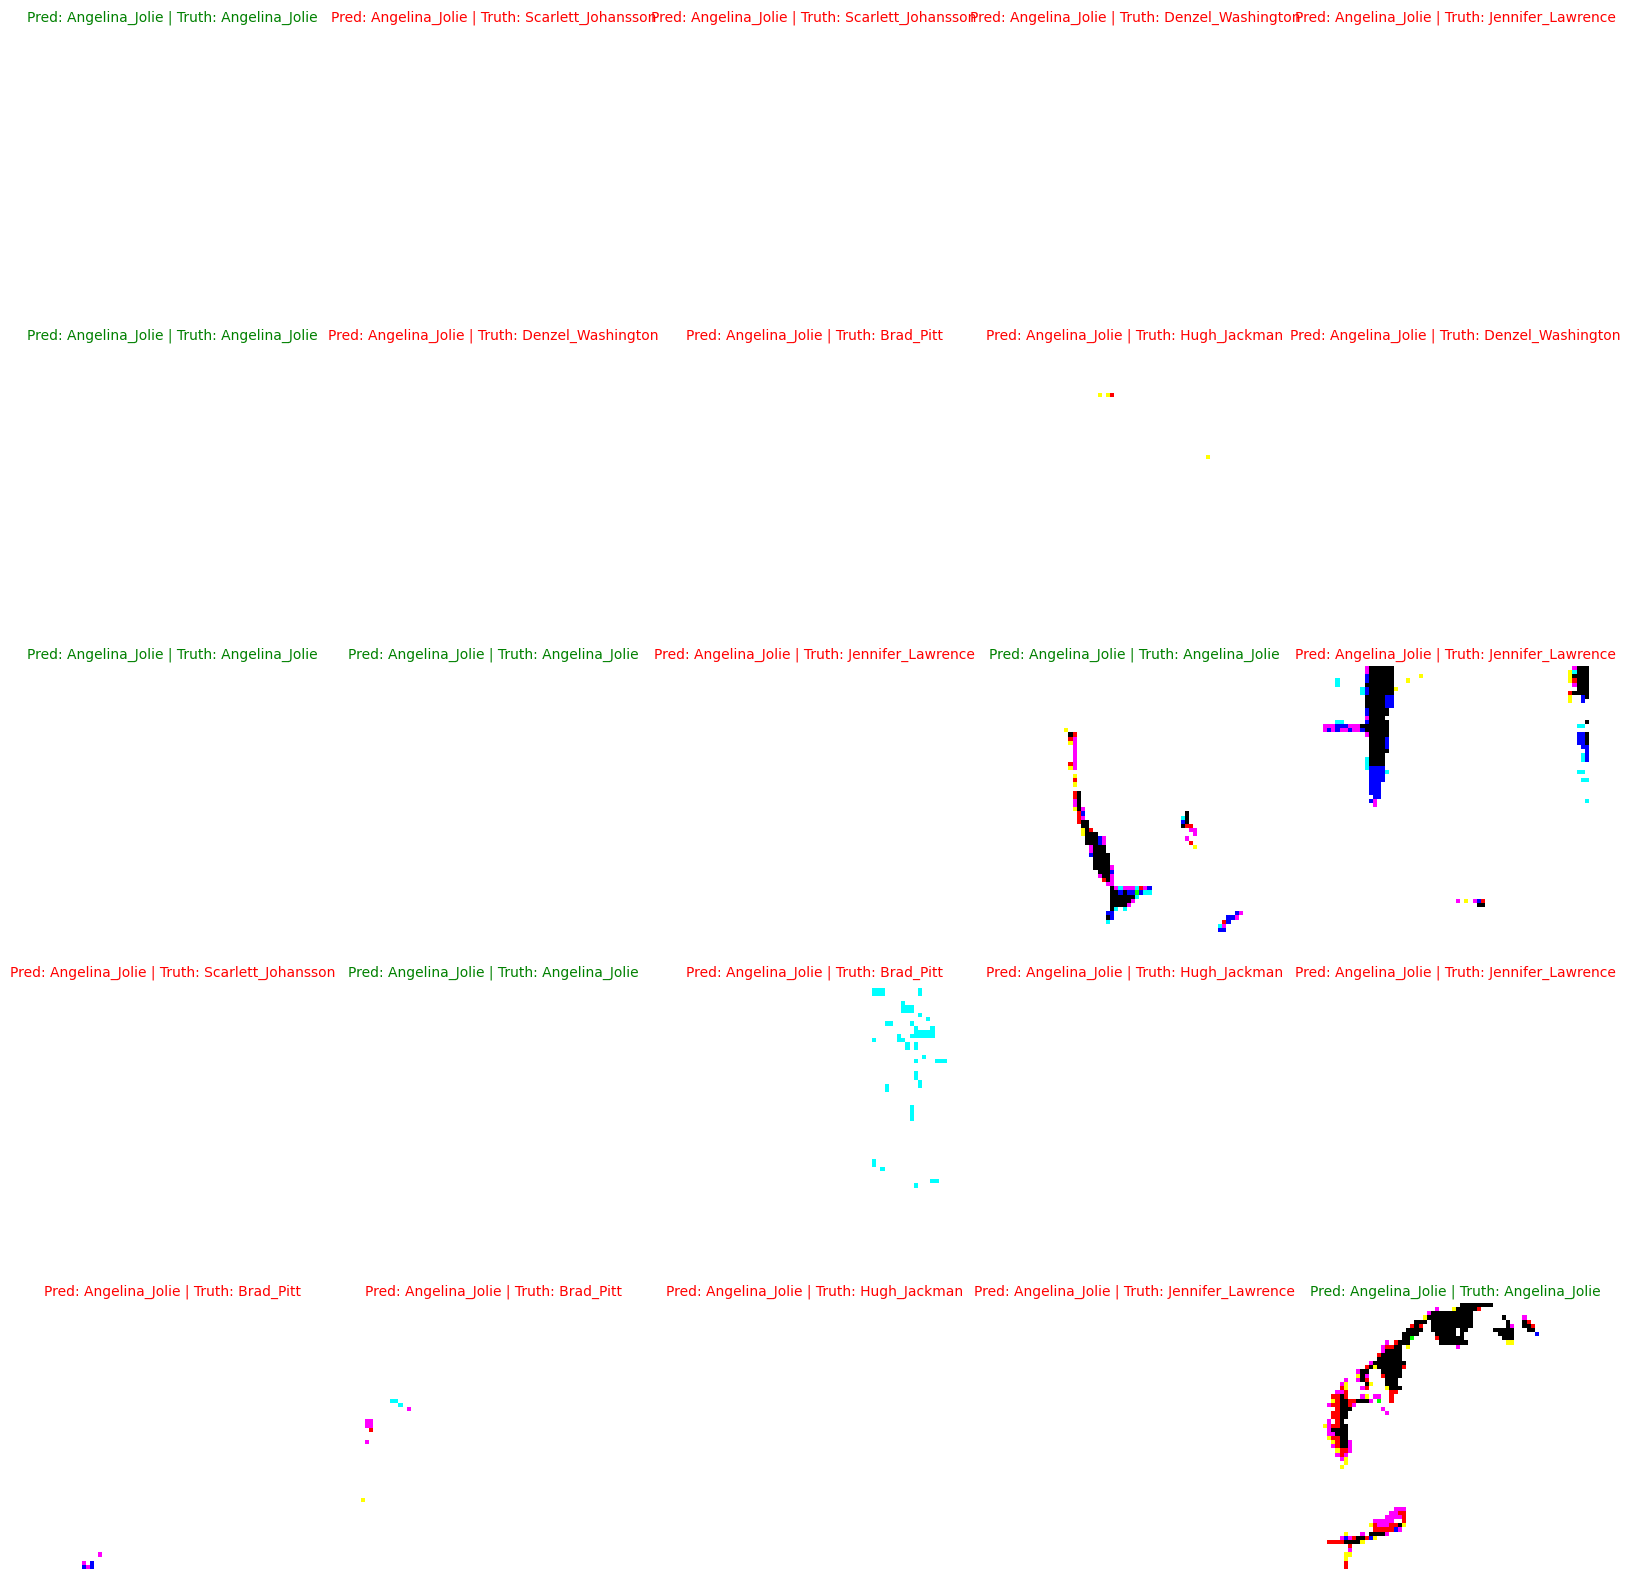

In [209]:
plt.figure(figsize=(20,20))
nrows = 5
ncols = 5

for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  sample_permute = sample.permute(1, 2, 0)

  # Plot the target image
  plt.imshow(sample_permute.squeeze())

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

